In [2]:
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from orion.data import load_signal, load_anomalies
from mlstars.custom.timeseries_preprocessing import rolling_window_sequences

from sigllm.forecasting import Signal2String, HF

# Load Time Series

In [3]:
signal_name = 'S-1'

df = load_signal(signal_name)[:200]

t, timeseries = df.T.values

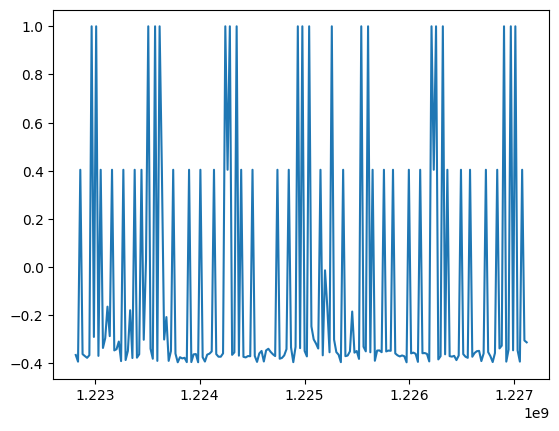

In [4]:
import matplotlib.pyplot as plt

plt.plot(t, timeseries);

In [5]:
# helper plotting function

def plot_results(x, title=None):
    median = np.median(x, axis=0)
    lower = np.quantile(x, 0.05, axis=0)
    upper = np.quantile(x, 0.95, axis=0)
    
    plt.plot(t[:stop], train)
    plt.plot(t[stop:], test, color='green', label='true')
    
    plt.plot(t[stop:], median, color='purple', label='pred');
    plt.fill_between(t[stop:], lower, upper, alpha=0.3, color='purple')

    if title:
        plt.title(title)
    
    plt.legend();

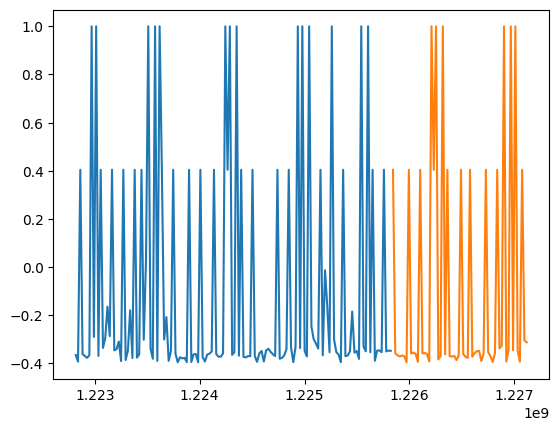

In [6]:
# split time series

stop = int(np.ceil(0.7 * len(timeseries)))

train, test = timeseries[:stop], timeseries[stop:]

plt.plot(t[:stop], train)
plt.plot(t[stop:], test);

In [7]:
converter = Signal2String(decimal=0, sep=',', space=False)

train_str = converter.transform(train) ## TODO: add seperator to the end and remove it from gpt.py

In [8]:
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'

model = HF(model_name, converter.sep)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
output = model.forecast(train_str, steps=len(test), samples=10, padding=1) ## TODO: fix length error

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2024-04-05 16:58:57.582653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 16:58:57.582692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 16:58:57.582713: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 16:58:57.588572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the ap

In [10]:
predictions = []
incomplete = 0
for o in output:
    pred = converter.reverse_transform(o, trunc=len(test))
    if len(pred) != len(test):
        incomplete += 1
        continue

    predictions.append(pred)

print(f"Recorded {incomplete} incomplete forecasts")
predictions = np.array(predictions)

Recorded 0 incomplete forecasts


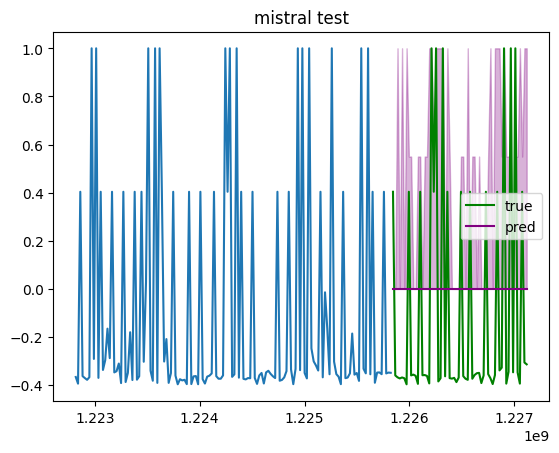

In [11]:
plot_results(predictions, title='mistral test')

# Run Model

In [12]:
# helper plotting function

def plot_results_windows(x, title=None):
    median = np.median(x.T, axis=0)
    lower = np.quantile(x.T, 0.05, axis=0)
    upper = np.quantile(x.T, 0.95, axis=0)
    
    plt.plot(t, timeseries)
    plt.plot(y_index, y, color='green', label='true')
    
    plt.plot(y_index, median, color='purple', label='pred');
    plt.fill_between(y_index, lower, upper, alpha=0.3, color='purple')

    if title:
        plt.title(title)
    
    plt.legend();

In [13]:
# scaler 

scaler = MinMaxScaler(feature_range=(0, 1))
timeseries = scaler.fit_transform(timeseries.reshape(-1, 1))

In [14]:
# make rolling windows

window_size = 140
step_size = 1
X, y, X_index, y_index = rolling_window_sequences(
    timeseries, t, 
    target_column=0, 
    target_size=1, 
    window_size=window_size, 
    step_size=step_size
)

In [22]:
# initialization

converter = Signal2String(decimal=2, sep=',', space=False, rescale=False)
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'
model = HF(model_name, converter.sep)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
results = []

steps = 10

for window in tqdm(X):
    input_str = converter.transform(window.flatten())
    output = model.forecast(input_str, steps=steps, samples=5, padding=1)
    results.append(output)

100%|██████████| 60/60 [02:54<00:00,  2.91s/it]


In [30]:
predictions = []
incomplete = 0
for output in tqdm(results):
    result = []
    for o in output:
        pred = converter.reverse_transform(o, trunc=1)
        if len(pred) != 1:
            incomplete += 1
            continue
            
        result.append(pred)
    predictions.append(result)
        

print(f"Recorded {incomplete} incomplete forecasts")
predictions = np.array(predictions)
predictions = predictions[:, :, 0]

predictions[predictions > 2] = predictions.mean()

100%|██████████| 60/60 [00:00<00:00, 18012.90it/s]

Recorded 0 incomplete forecasts


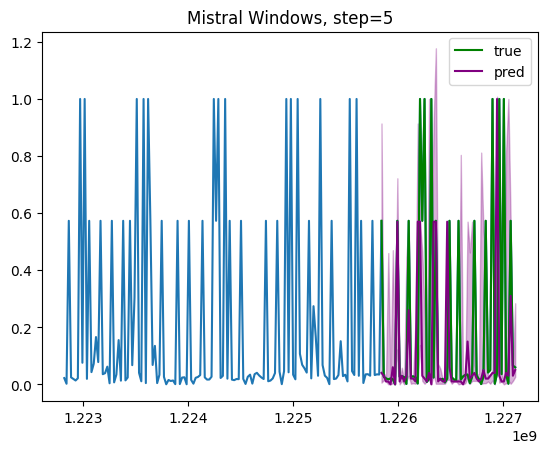

In [31]:
plot_results_windows(predictions, title='Mistral Windows, step=5')